Ανίχνευση πετρελαιοκηλίδας μέσω εικόνας δορυφόρου:

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
import random
import pandas as pd
rcParams['figure.figsize'] = 10 ,10

Η εικόνα η οποία έχουμε στην διάθεση μας είναι η παρακάτω.

In [2]:
img_path = "Input/oil_spil.jpg"
img = cv2.imread(img_path)
flat_img = np.float32(img.reshape((-1,3)))

In [3]:
flat_img.shape[:2]

(312000, 3)

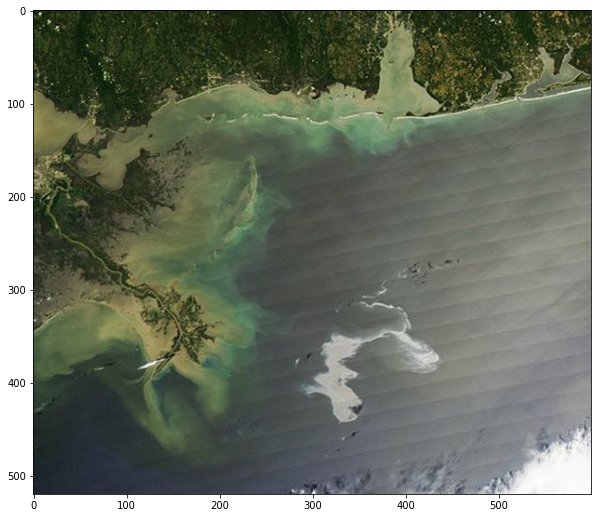

In [4]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Στόχος μας είναι να εφαρμόσουμε τεχνικές κατάτμησης στην εικόνα ώστε να απομονώσουμε από την εικόνα τo σημείo που βρίσκεται η πετρελαιοκηλίδα.

Οι αλγόριθμοι συσταδοποίησης οι οποίοι επελαξα είναι ο **K Means** και ο **Mean shift**. 

In [5]:
def run_mean_shift(flat_image, bandwidth):
    
    ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)
    ms.fit(flat_image)
    labels_ms = ms.labels_
    labels_flat = labels_ms.reshape((img.shape[:-1]))

    return labels_flat, ms.cluster_centers_

In [6]:
def run_kmeans(flat_image, clusters):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,labels_km,centers_km = cv2.kmeans(flat_image,
                                    clusters, None, criteria,
                                    10, cv2.KMEANS_RANDOM_CENTERS)
    labels_flat = labels_km.reshape((img.shape[:-1]))
    return labels_flat,centers_km

Πάμε να δούμε λοιπόν πως αντιμετωπίζουν την εικόνα μας χωρίς καθόλου θόρυβο.

## K means

In [7]:
K = 6
labels_flat,centers_km = run_kmeans(flat_img, K)
#result of clustering
reduced_km = np.uint8(centers_km)[labels_flat]
for i, c in enumerate(centers_km):
    #get the mask of each cluster
    mask = cv2.inRange(labels_flat, i, i)
    mask = np.dstack([mask]*3) # Make it 3 channel
    #get the bitwise result of each cluster
    reduced_ = cv2.bitwise_and(reduced_km, mask)
    cv2.imwrite('Output/Q3/NoNoise/K_means/Cluster{}.jpg'.format(i+1), reduced_)

Εμφανίζουμε τα αποτελέσματα:

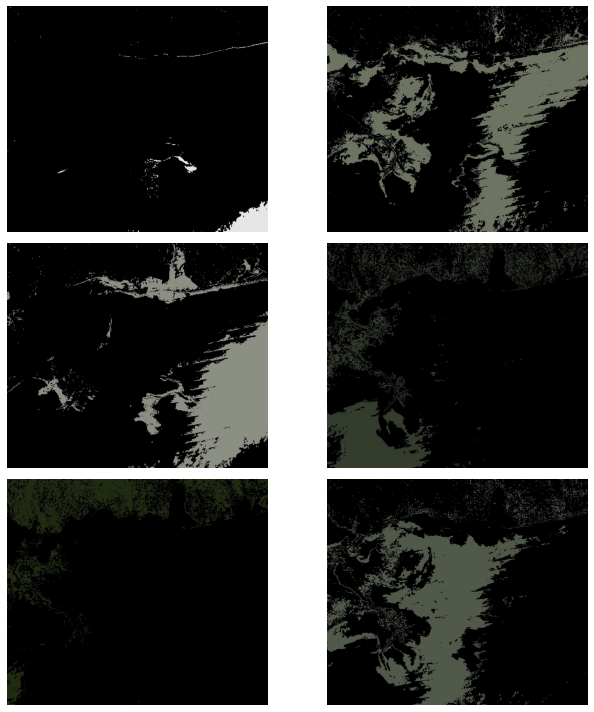

In [8]:
import os
path = r"Output\Q3\NoNoise\K_means"
Images = ( [
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])

#plot the images
import matplotlib.image as mpimg 
ROW = 3
COLUMN = 2
for i in range(len(Images)):
    image = mpimg.imread(path + '\\' + Images[i]) 
    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(image)  
    plt.axis('off')  # do not show axis value
plt.tight_layout()   # automatic padding between subplots
plt.show()

## Mean shift

In [9]:
bandwidth = estimate_bandwidth(flat_img, quantile=0.1, n_samples=100)
labels_ms, centers_ms = run_mean_shift(flat_img, bandwidth)
reduced_ms = np.uint8(centers_ms)[labels_ms]

for i, c in enumerate(centers_ms):
    mask = cv2.inRange(labels_ms, i, i)
    mask = np.dstack([mask]*3) # Make it 3 channel
    reduced_ = cv2.bitwise_and(reduced_ms, mask)
    cv2.imwrite('Output/Q3/NoNoise/MeanShift/Cluster{}.jpg'.format(i+1), reduced_)

Εμφανίζουμε τα αποτελέσματα:

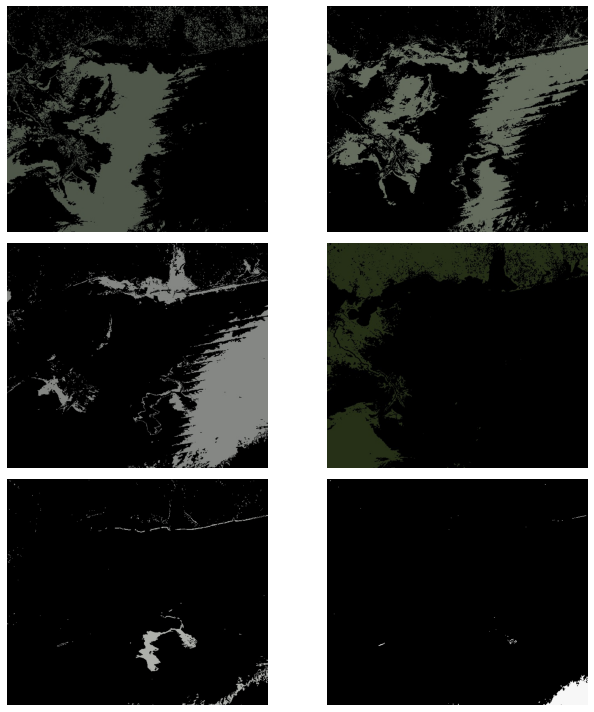

In [10]:
path = r"Output\Q3\NoNoise\MeanShift"
Images = ( [
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])

#plot the images
import matplotlib.image as mpimg 
ROW = 3
COLUMN = 2
for i in range(len(Images)):
    image = mpimg.imread(path + '\\' + Images[i]) 
    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(image)  
    plt.axis('off')  # do not show axis value
plt.tight_layout()   # automatic padding between subplots
plt.show()

Αφου καταφέραμε να κατατμήσουμε την εικόνα σε διάφορα clusters θα πρέπει να βρούμε έναν τρόπο να ελέγξουμε αν υπάρχει κάποιο cluster το οποίο κατάφερε να απομόνωση την πετρελαιοκηλίδα. 

Για να το καταφέρουμε αυτό θα πρέπει να φτιάξουμε χειροκίνητα μια annotated εικόνα όπου θα συγκρίνουμε το κάθε pixel της με αυτό της εικόνας που ανήκει σε ένα cluster.

Πάμε λοιπών να διαβάσουμε την εικόνα και να την μετατρέψουμε σε black & white.

In [11]:
img_oil_spoil = cv2.imread('Input/y_true.jpg')
gray_oil_spoil = cv2.cvtColor(img_oil_spoil, cv2.COLOR_BGR2GRAY)
(_ , blackAndWhiteImage_oil_spoil) = cv2.threshold(gray_oil_spoil,
                                                   90, 255, cv2.THRESH_BINARY)

Το επόμενο βήμα είναι να δημιουργήσουμε ένα διάνυσμα το οποίο για κάθε τιμή του pixel που είναι 255 στην αντίστοιχη θέση θα έχει 1, αν η τιμή του pixel είναι 0 θα είναι 0. Την ίδια  ενέργεια θα κάνουμε και για τις εικόνες που δημιουργήσαμε από τα clusters.
Με αυτό τον τρόπο θα αναπαριστάμε την κάθε εικόνα ως ένα διάνυσμα 2 κλάσεων (0 και 1). Έτσι θα είμαστε σε θέση να συγκρίνουμε τις δυο εικόνες. 

(312000,)

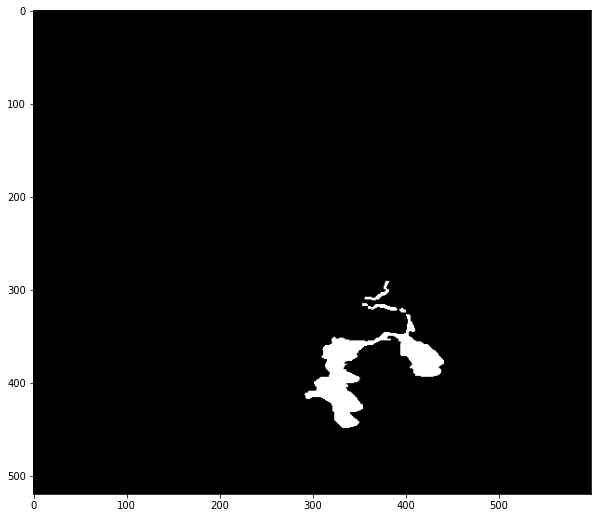

In [12]:
y_true = np.zeros(blackAndWhiteImage_oil_spoil.shape[:2])
y_true[np.where(blackAndWhiteImage_oil_spoil == 255)] = 1
plt.imshow(y_true, cmap='gray')
y_true = y_true.flatten() 
y_true.shape[:]

Φτιάχνουμε ένα dataframe ώστε να αποθηκεύσουμε τις συγκρίσεις.

In [13]:
columns = ['Method', 'Cluster', 'Ammount of noise', 'Jaccard Score', 'F1 score','Image path']
pd.options.display.float_format = '{:,.2f}'.format
results_DF = pd.DataFrame(columns=columns)

Η παρακάτω συνάρτηση δέχεται μια εικόνα την μετατρέπει σε black & white και μας επιστρέφει το διάνυσμα 2 κλάσεων.

In [14]:
def getY_pred(image, bottom=25):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (_ , blackAndWhiteImage) = cv2.threshold(grayImage,
                                            bottom, 255, cv2.THRESH_BINARY)
    y_pred = np.zeros(img.shape[:2])
    y_pred[np.where(blackAndWhiteImage == 255)] = 1
    y_pred = y_pred.flatten() 
    return y_pred

In [15]:
#define function to create some noise to an image
def rand_noise(image, ammount):

    output = np.zeros(image.shape,np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.randint(0, 9)
            rdn2 = random.randint(0, 9)
            
            output[i][j] = image[i][j] + ammount*rdn*image[i][j] - ammount*rdn2*image[i][j]
    return output

Με τον παρακάτω κωδικά έχουμε μαζέψει όλα τα βήματα που δείξαμε παραπάνω και τα εφαρμόζουμε στην ίδια εικόνα αφού έχει επηρεαστεί από θόρυβο 0%, 5%, 10%, 20%.

In [16]:
ammounts = [0, 0.05, 0.10, 0.20]

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 6

for num, ammount in enumerate(ammounts):
    
    img_noisy = rand_noise(img, ammount)
    flat_image_noisy = np.float32(img_noisy.reshape((-1,3)))
    
    bandwidth = estimate_bandwidth(flat_image_noisy, quantile=0.1, n_samples=100)
    labels_ms, centers_ms = run_mean_shift(flat_image_noisy, bandwidth)
    reduced_ms = np.uint8(centers_ms)[labels_ms]
    
    labels_km, centers_km = run_kmeans(flat_image_noisy, K)
    reduced_km = np.uint8(centers_km)[labels_km]
    
    for i, c in enumerate(centers_ms):
        
        mask = cv2.inRange(labels_ms, i, i)
        mask = np.dstack([mask]*3) # Make it 3 channel
        reduced_ = cv2.bitwise_and(reduced_ms, mask)
        
        path = 'Output/Q3/MeanShift/Noise{}/Cluster{}.jpg'.format(num, i+1)
        cv2.imwrite(path, reduced_)
        #get they y_ped of  each cluster
        y_pred = getY_pred(reduced_)
        #get the jaccard_score
        scoreJ = jaccard_score(y_true, y_pred)
        #get the f1_score using macro because of the imbalance data
        score_f1 = f1_score(y_true, y_pred, average='macro')
        results_DF.loc[len(results_DF)] = ['MeanShift'] + [i+1] + [ammount] + [scoreJ] + [score_f1] + ['Noise{}_Cluster{}.jpg'.format(num, i+1)]
    
    for i, c in enumerate(centers_km):
        
        mask = cv2.inRange(labels_km, i, i)
        mask = np.dstack([mask]*3) # Make it 3 channel
        reduced_ = cv2.bitwise_and(reduced_km, mask)
        
        
        path = 'Output/Q3/K_means/Noise{}/Cluster{}.jpg'.format(num, i+1)
        cv2.imwrite(path, reduced_)
        y_pred = getY_pred(reduced_)
        scoreJ = jaccard_score(y_true, y_pred)
        score_f1 = f1_score(y_true, y_pred, average='macro')
        results_DF.loc[len(results_DF)] = ['K_means'] + [i+1] + [ammount] + [scoreJ] + [score_f1] + ['Noise{} Cluster{}.jpg'.format(num, i+1)]

In [17]:
results_DF

,Method,Cluster,Ammount of noise,Jaccard Score,F1 score,Image path
0,MeanShift,1,0,0.00,0.42,Noise0_Cluster1.jpg
1,MeanShift,2,0,0.01,0.43,Noise0_Cluster2.jpg
2,MeanShift,3,0,0.01,0.45,Noise0_Cluster3.jpg
3,MeanShift,4,0,0.00,0.43,Noise0_Cluster4.jpg
4,MeanShift,5,0,0.38,0.77,Noise0_Cluster5.jpg
5,MeanShift,6,0,0.01,0.50,Noise0_Cluster6.jpg
6,K_means,1,0,0.00,0.47,Noise0 Cluster1.jpg
7,K_means,2,0,0.05,0.49,Noise0 Cluster2.jpg
8,K_means,3,0,0.08,0.56,Noise0 Cluster3.jpg
9,K_means,4,0,0.00,0.45,Noise0 Cluster4.jpg


Βλέπουμε τα 3 καλύτερα αποτελέσματα με βάση το Jaccard Score.

In [18]:
results_DF.nlargest(3, 'Jaccard Score')

,Method,Cluster,Ammount of noise,Jaccard Score,F1 score,Image path
4,MeanShift,5,0,0.38,0.77,Noise0_Cluster5.jpg
24,K_means,4,0.05,0.13,0.60,Noise1 Cluster4.jpg
19,MeanShift,8,0.05,0.08,0.57,Noise1_Cluster8.jpg


Βλέπουμε τα 3 καλύτερα αποτελέσματα με βάση το F1 score.

In [19]:
results_DF.nlargest(3, 'F1 score')

,Method,Cluster,Ammount of noise,Jaccard Score,F1 score,Image path
4,MeanShift,5,0,0.38,0.77,Noise0_Cluster5.jpg
24,K_means,4,0.05,0.13,0.60,Noise1 Cluster4.jpg
19,MeanShift,8,0.05,0.08,0.57,Noise1_Cluster8.jpg


Πάμε να δούμε το καλύτερο αποτέλεσμα το οποίο είναι το cluster 5 του mean shift στην εικόνα χωρίς θόρυβο:

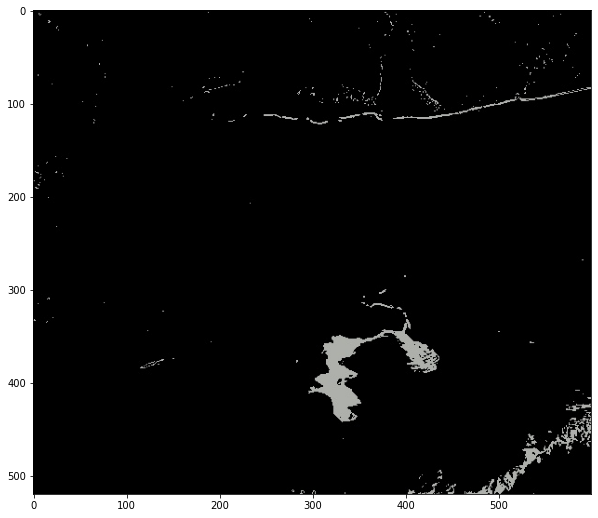

In [20]:
plt.imshow(cv2.cvtColor(cv2.imread("Output/Q3/Meanshift/Noise0/Cluster5.jpg"), cv2.COLOR_BGR2RGB))

Βλέπουμε ότι η συστάδα αυτή έχει καλύψει το μεγαλύτερο μέρος της πετρελαιοκηλίδας παρόλα αυτά υπάρχει αρκετός θόρυβος στα άκρα της εικόνας. Ας εφαρμόσουμε ένα median filter για να εξαλείψουμε ένα μέρος αυτού. 

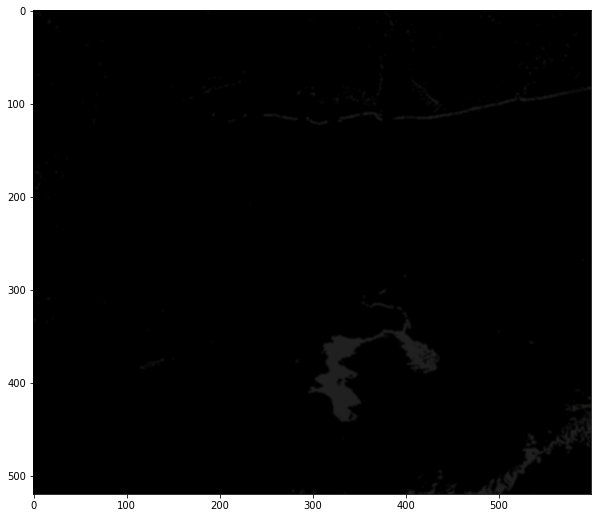

In [21]:
img = cv2.imread("Output/Q3/Meanshift/Noise0/Cluster5.jpg")
kernel = np.ones((3,3),np.float32)/50
dst = cv2.filter2D(img,-1,kernel)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

Μετατρέπουμε την εικόνα μας σε black & white.

In [25]:
img = cv2.imread("Output/Q3/Meanshift/Noise0/Cluster5.jpg")

In [26]:
dst = cv2.filter2D(img,-1,kernel)

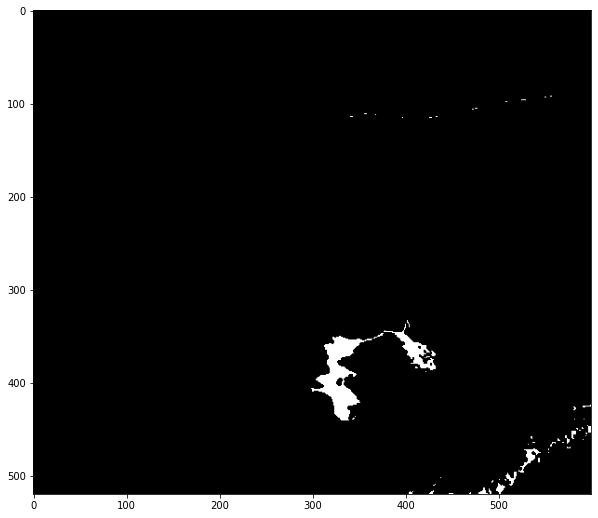

In [37]:
grayImage = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
(_ , blackAndWhiteImage) = cv2.threshold(grayImage,  25, 255, cv2.THRESH_BINARY)

plt.imshow(blackAndWhiteImage, cmap='gray', vmin=0, vmax=255)

In [40]:
path = 'Output/Q3/best.jpg'
cv2.imwrite(path, blackAndWhiteImage)

True

Ξανά μετράμε το Jacard Score.

In [38]:
y_pred = np.zeros(img.shape[:2])
y_pred[np.where(blackAndWhiteImage == 255)] = 1
y_pred = y_pred.flatten() 
scoreJ = jaccard_score(y_true, y_pred)
print(scoreJ)

0.44373489817052125


Καταφέραμε και απομονώσαμε σε ικανοποιητικό βαθμό την πετρελαιοκηλίδα. 

Εμφανίζουμε το δεύτερο καλύτερο αποτέλεσμα. 

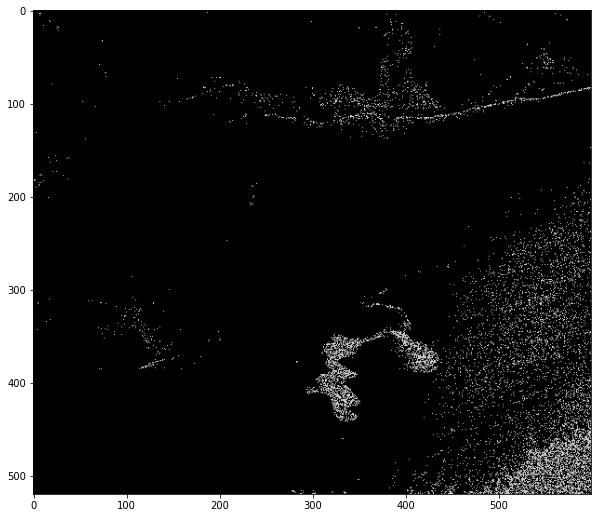

In [39]:
rcParams['figure.figsize'] = 10 ,10
plt.imshow(cv2.cvtColor(cv2.imread("Output/Q3/K_means/Noise1/Cluster4.jpg"), cv2.COLOR_BGR2RGB))

Βλέπουμε ότι ο θόρυβος έχει επηρεάσει σημαντικά το αποτέλεσμα. 